In [ ]:
import logging
import pathlib
import sys

import pandas as pd
from pandas import DataFrame

from topollm.analysis.compare_sampling_methods.filter_dataframe_based_on_filters_dict import (
    filter_dataframe_based_on_filters_dict,
)
from topollm.analysis.compare_sampling_methods.load_and_concatenate_saved_dataframes import (
    load_and_concatenate_saved_dataframes,
)
from topollm.analysis.compare_sampling_methods.make_plots import (
    create_boxplot_of_mean_over_different_sampling_seeds,
    generate_fixed_params_text,
)
from topollm.config_classes.constants import NAME_PREFIXES_TO_FULL_DESCRIPTIONS, TOPO_LLM_REPOSITORY_BASE_PATH
from topollm.typing.enums import Verbosity

# Create a logger
default_logger: logging.Logger = logging.getLogger(name=__name__)
default_logger.setLevel(level=logging.DEBUG)

# Create a stream handler
stream_handler = logging.StreamHandler(stream=sys.stdout)
stream_handler.setLevel(level=logging.DEBUG)

# Create a formatter and attach it to the handler
formatter = logging.Formatter(fmt="[%(asctime)s][%(levelname)8s][%(name)s] %(message)s (%(filename)s:%(lineno)s)")
stream_handler.setFormatter(fmt=formatter)

# Add the handler to the logger
if not default_logger.handlers:  # Avoid adding duplicate handlers in case the cell is re-executed
    default_logger.addHandler(hdlr=stream_handler)

verbosity: Verbosity = Verbosity.NORMAL
logger: logging.Logger = default_logger

# Example usage
logger.debug(msg="This is a debug message.")
logger.info(msg="This is an info message.")

In [ ]:
comparisons_folder_base_path = pathlib.Path(
    TOPO_LLM_REPOSITORY_BASE_PATH,
    "data/analysis/sample_sizes/",
    "run_general_comparisons/",
    "array_truncation_size=5000/",
    "analysis/twonn/",
)

concatenated_df: DataFrame = load_and_concatenate_saved_dataframes(
    root_dir=comparisons_folder_base_path,
)

columns_to_investigate: list[str] = [
    "data_full",
    "data_subsampling_full",
    "model_partial_name",
]

for column_name in columns_to_investigate:
    print(30 * "=")
    print(
        f"Unique values in column '{column_name = }':",
    )
    print(
        concatenated_df[column_name].unique(),
    )

concatenated_df.info()

In [ ]:
concatenated_df

### Investigate the influence of the data subsampling method on the results

data_subsampling_number_of_samples = 8000: filtered_concatenated_df_for_number_of_samples.shape = (3, 38)
data_subsampling_number_of_samples = 18000: filtered_concatenated_df_for_number_of_samples.shape = (15, 38)
data_subsampling_number_of_samples = 10000: filtered_concatenated_df_for_number_of_samples.shape = (15, 38)
data_subsampling_number_of_samples = 20000: filtered_concatenated_df_for_number_of_samples.shape = (15, 38)
data_subsampling_number_of_samples = 6000: filtered_concatenated_df_for_number_of_samples.shape = (3, 38)
data_subsampling_number_of_samples = 16000: filtered_concatenated_df_for_number_of_samples.shape = (15, 38)
data_subsampling_number_of_samples = 14000: filtered_concatenated_df_for_number_of_samples.shape = (15, 38)
data_subsampling_number_of_samples = 4000: filtered_concatenated_df_for_number_of_samples.shape = (3, 38)
data_subsampling_number_of_samples = 2000: filtered_concatenated_df_for_number_of_samples.shape = (3, 38)
data_subsampling_number_of_samples =

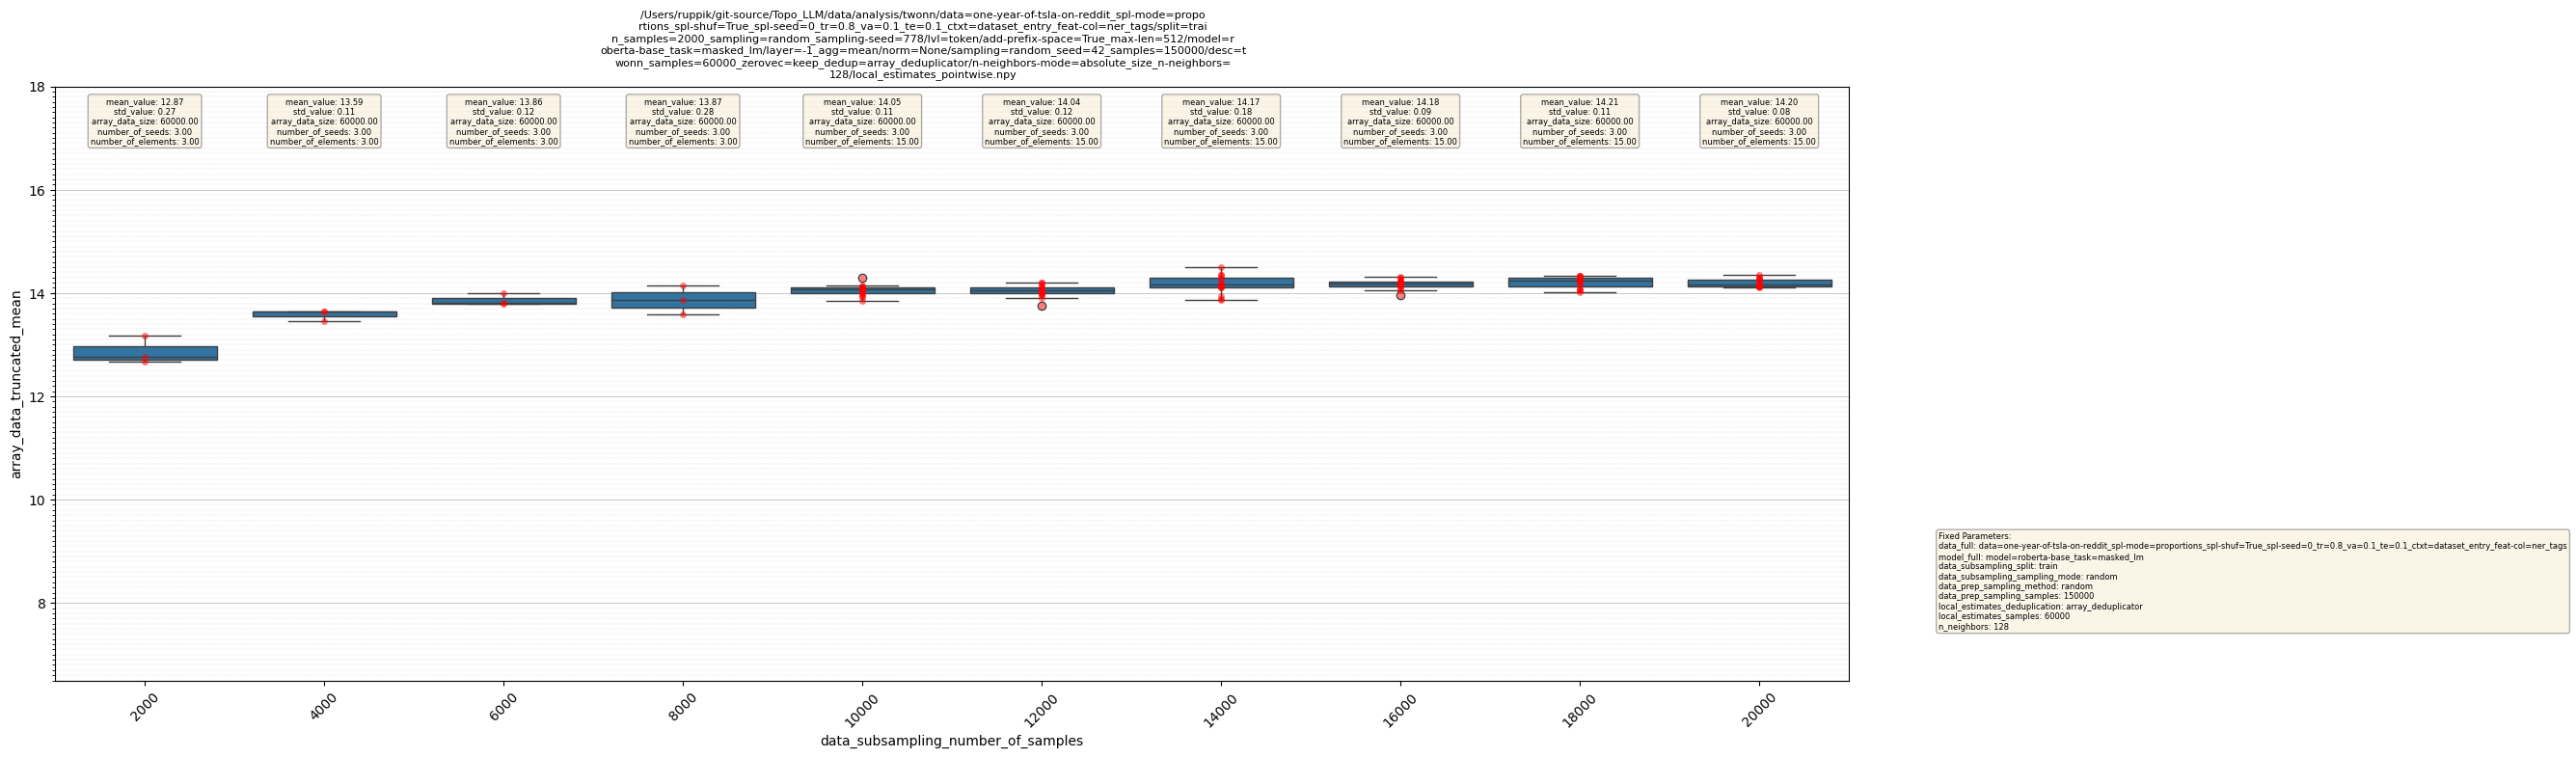

In [12]:
from topollm.analysis.compare_sampling_methods.make_plots import Y_AXIS_LIMITS_ONLY_FULL


def log_subsampling_number_of_samples_values(
    filtered_concatenated_df: pd.DataFrame,
) -> None:
    """For every occurence of value in "data_subsampling_number_of_samples", check how many rows are present in the filtered dataframe."""
    data_subsampling_number_of_samples_values = filtered_concatenated_df["data_subsampling_number_of_samples"].unique()

    for data_subsampling_number_of_samples in data_subsampling_number_of_samples_values:
        data_subsampling_number_of_samples_filters_dict = {
            "data_subsampling_number_of_samples": data_subsampling_number_of_samples,
        }

        filtered_concatenated_df_for_number_of_samples: DataFrame = filter_dataframe_based_on_filters_dict(
            df=filtered_concatenated_df,
            filters_dict=data_subsampling_number_of_samples_filters_dict,
        )

        print(
            f"{data_subsampling_number_of_samples = }: {filtered_concatenated_df_for_number_of_samples.shape = }",
        )

    print(
        "Unique data_subsampling_sampling_seed:\n",
        filtered_concatenated_df["data_subsampling_sampling_seed"].unique(),
    )


def run_data_subsampling_number_of_samples_analysis(
    concatenated_df: pd.DataFrame,
    figsize: tuple[int, int] = (24, 8),
) -> None:
    data_full = concatenated_df["data_full"].unique()[1]
    data_subsampling_split = concatenated_df["data_subsampling_split"].unique()[1]
    data_subsampling_sampling_mode_list_to_process: str = "random"

    model_full = concatenated_df["model_full"].unique()[0]

    concatenated_filters_dict = {
        "data_full": data_full,
        "model_full": model_full,
        "data_subsampling_split": data_subsampling_split,
        "data_subsampling_sampling_mode": data_subsampling_sampling_mode_list_to_process,
        "data_prep_sampling_method": "random",
        "data_prep_sampling_samples": 150_000,
        NAME_PREFIXES_TO_FULL_DESCRIPTIONS["dedup"]: "array_deduplicator",
        "local_estimates_samples": 60_000,
        "n_neighbors": 128,
    }

    filtered_concatenated_df: DataFrame = filter_dataframe_based_on_filters_dict(
        df=concatenated_df,
        filters_dict=concatenated_filters_dict,
    )

    log_subsampling_number_of_samples_values(
        filtered_concatenated_df=filtered_concatenated_df,
    )

    print(f"{filtered_concatenated_df.shape = }")

    # # # #
    # START Additional data cleaning:
    # Remove those samples where "array_data.size" is smaller than 30_000

    filtered_concatenated_df_cleaned = filtered_concatenated_df[filtered_concatenated_df["array_data.size"] >= 50_000]

    # END Additional data cleaning
    # # # #

    data_for_different_data_subsampling_number_of_samples_analysis_df: DataFrame = filtered_concatenated_df_cleaned

    fixed_params_text: str = generate_fixed_params_text(
        filters_dict=concatenated_filters_dict,
    )

    x_column_name = "data_subsampling_number_of_samples"

    for y_min, y_max in Y_AXIS_LIMITS_ONLY_FULL.values():
        # for y_min, y_max in [(6.0, 10.0)]:
        create_boxplot_of_mean_over_different_sampling_seeds(
            subset_local_estimates_df=data_for_different_data_subsampling_number_of_samples_analysis_df,
            plot_save_path=None,  # TODO: Select path
            raw_data_save_path=None,  # TODO: Select path
            x_column_name=x_column_name,
            y_column_name="array_data_truncated_mean",
            seed_column_name="data_subsampling_sampling_seed",
            fixed_params_text=fixed_params_text,
            figsize=figsize,
            y_min=y_min,
            y_max=y_max,
            logger=logger,
        )


run_data_subsampling_number_of_samples_analysis(
    concatenated_df=concatenated_df,
    figsize=(24, 8),
)